In [26]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Configurar MLflow
#mlflow.set_tracking_uri("http://localhost:5000")
#mlflow.set_experiment("toyota_project")

In [7]:
# Cargar dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/dodobeatle/dataeng-datos/refs/heads/main/ToyotaCorolla.csv",
    encoding="utf8",
    engine="python"
)

## 1. Vemos la dimensión del dataset

In [8]:
df.shape

(1436, 37)

## 2. Info general del dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

## 3. Descripción del dataset

In [10]:
df.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,...,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,721.555014,10730.824513,55.947075,5.548747,1999.625348,68533.259749,101.502089,0.674791,0.055710,1576.85585,...,0.580084,0.561978,0.977716,0.146240,0.256964,0.300139,0.770195,0.204735,0.145543,0.277855
std,416.476890,3626.964585,18.599988,3.354085,1.540722,37506.448872,14.981080,0.468616,0.229441,424.38677,...,0.493717,0.496317,0.147657,0.353469,0.437111,0.458478,0.420854,0.403649,0.352770,0.448098
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.750000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,721.500000,9900.000000,61.000000,5.000000,1999.000000,63389.500000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1081.250000,11950.000000,70.000000,8.000000,2001.000000,87020.750000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14404\3731943685.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Fuel_Type",palette="pastel")


<Axes: xlabel='Fuel_Type', ylabel='count'>

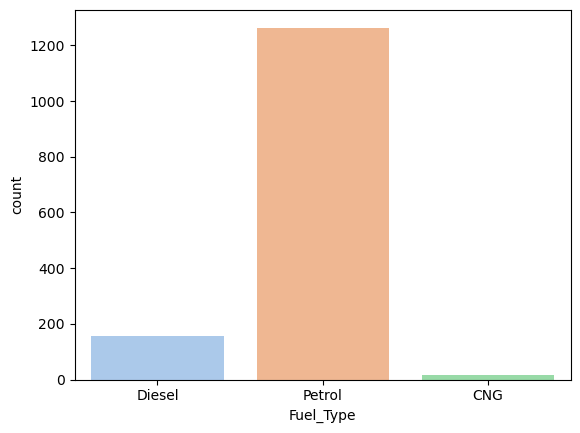

In [13]:
sns.countplot(data=df, x="Fuel_Type",palette="pastel")

In [20]:
print(df.columns.tolist())


['Id', 'Model', 'Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'cc', 'Doors', 'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Tow_Bar']


In [16]:
df.isnull().sum()

Id                  0
Model               0
Price               0
Age_08_04           0
Mfg_Month           0
Mfg_Year            0
KM                  0
Fuel_Type           0
HP                  0
Met_Color           0
Automatic           0
cc                  0
Doors               0
Cylinders           0
Gears               0
Quarterly_Tax       0
Weight              0
Mfr_Guarantee       0
BOVAG_Guarantee     0
Guarantee_Period    0
ABS                 0
Airbag_1            0
Airbag_2            0
Airco               0
Automatic_airco     0
Boardcomputer       0
CD_Player           0
Central_Lock        0
Powered_Windows     0
Power_Steering      0
Radio               0
Mistlamps           0
Sport_Model         0
Backseat_Divider    0
Metallic_Rim        0
Radio_cassette      0
Tow_Bar             0
dtype: int64

## Análisis univariado

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14404\757379194.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Fuel_Type", y="Price", palette="Set2",
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14404\757379194.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Fuel_Type", y="Price", palette="Set2",


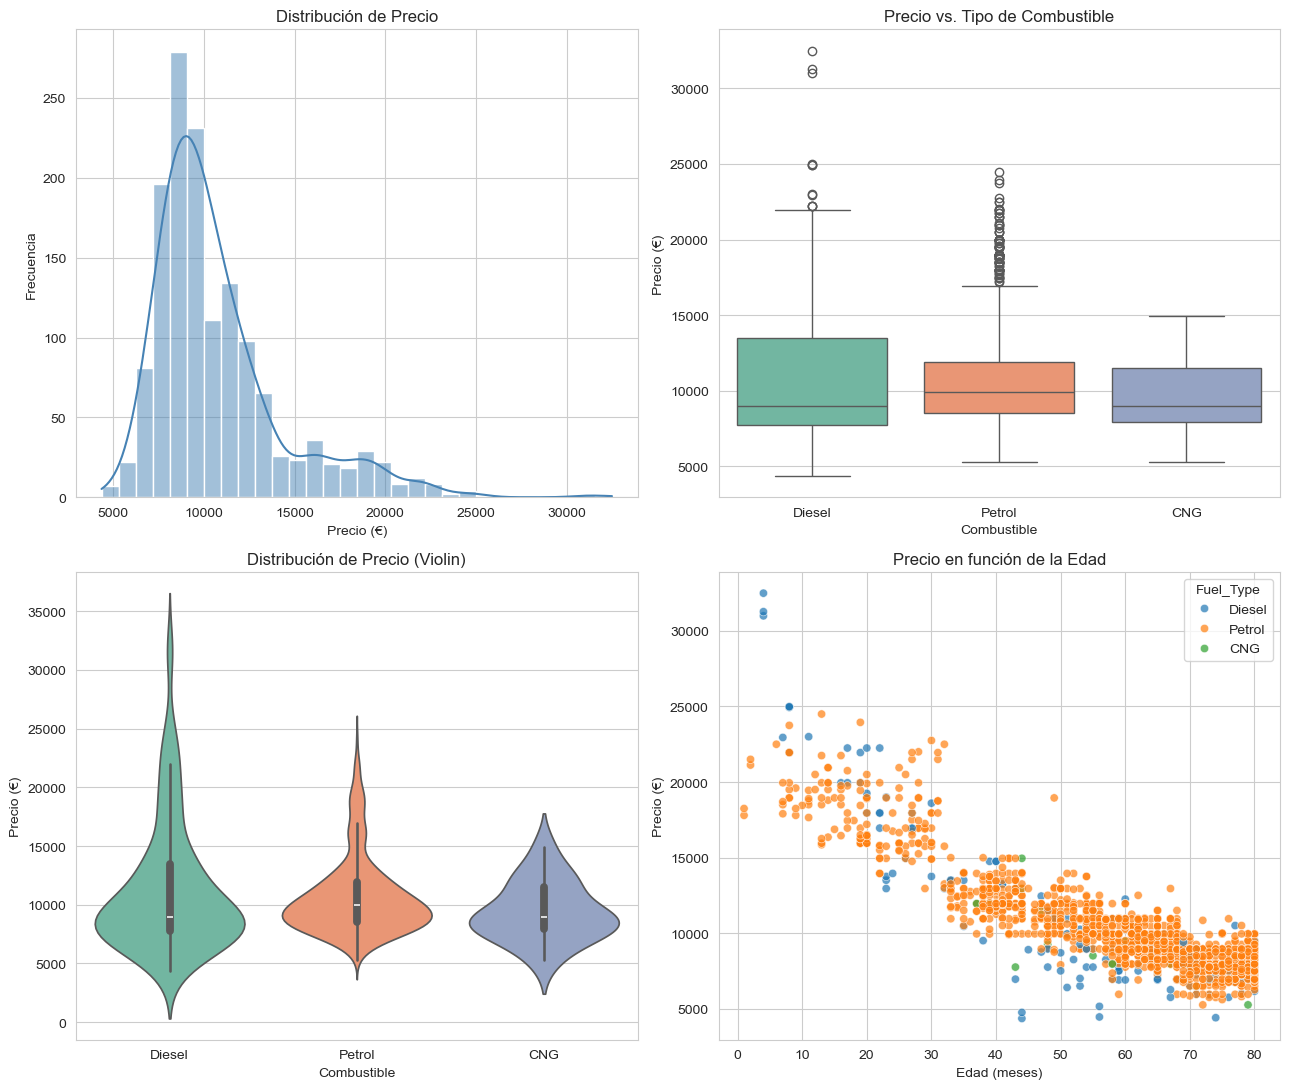

In [23]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(13, 11))
# (a) Histograma de precios
sns.histplot(data=df, x="Price", bins=30, kde=True,
             ax=axs[0, 0], color="steelblue")
axs[0, 0].set(title="Distribución de Precio", xlabel="Precio (€)", ylabel="Frecuencia")

# (b) Boxplot de precio por tipo de combustible
sns.boxplot(data=df, x="Fuel_Type", y="Price", palette="Set2",
            ax=axs[0, 1])
axs[0, 1].set(title="Precio vs. Tipo de Combustible", xlabel="Combustible", ylabel="Precio (€)")

# (c) Violinplot de precio por tipo de combustible
sns.violinplot(data=df, x="Fuel_Type", y="Price", palette="Set2",
               ax=axs[1, 0])
axs[1, 0].set(title="Distribución de Precio (Violin)", xlabel="Combustible", ylabel="Precio (€)")

# (d) Scatter Age vs Price coloreado por FuelType
sns.scatterplot(data=df, x="Age_08_04", y="Price", hue="Fuel_Type",
                ax=axs[1, 1], alpha=0.7)
axs[1, 1].set(title="Precio en función de la Edad",
              xlabel="Edad (meses)", ylabel="Precio (€)")

# 4. Ajustar espacios y mostrar
plt.tight_layout()
plt.show()

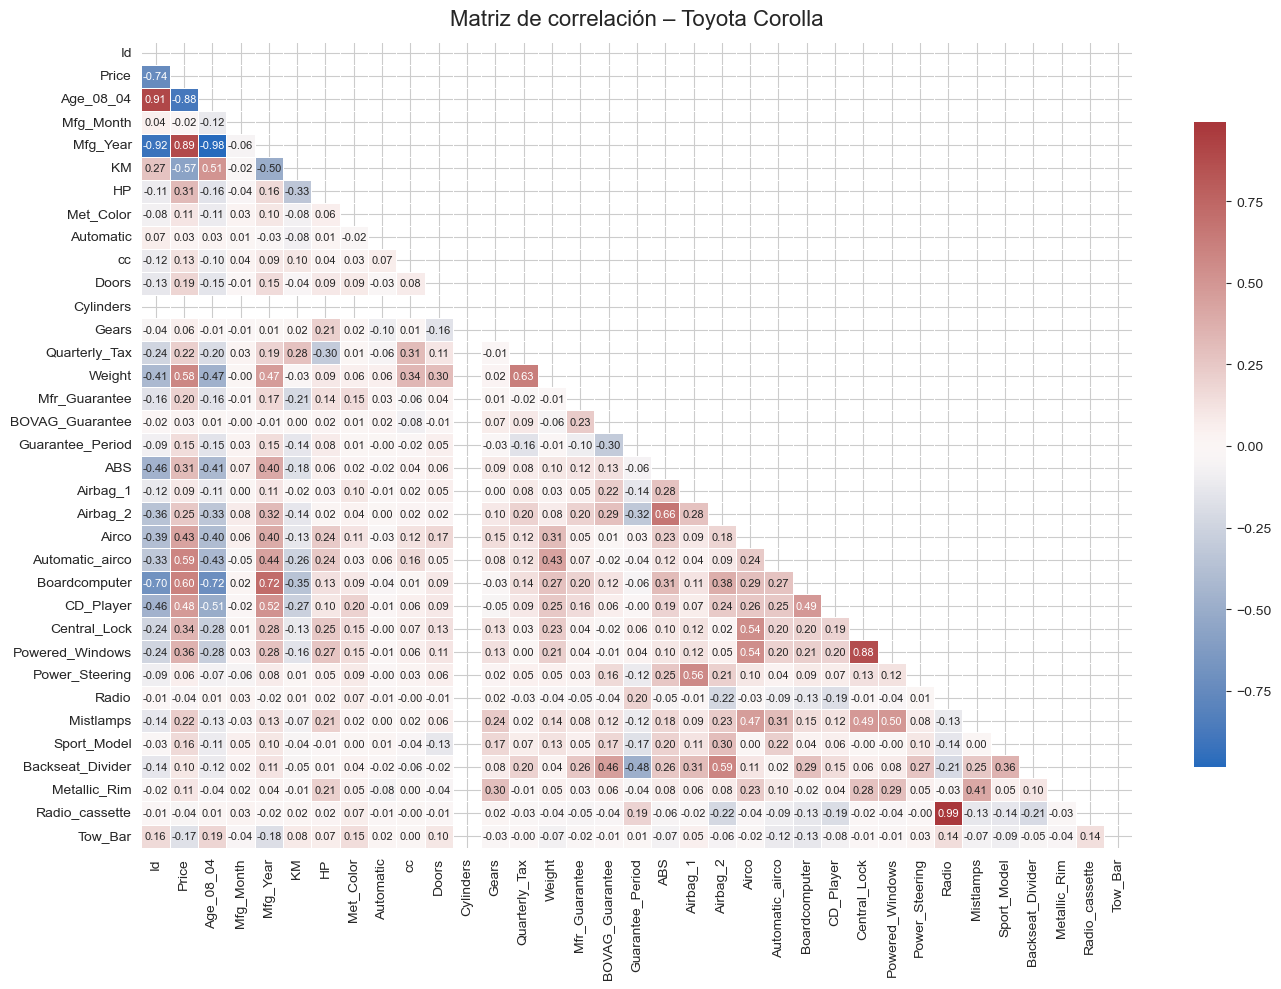

In [27]:
# 2. Variables numéricas
num_df = df.select_dtypes(include="number")

# 3. Matriz de correlación
corr = num_df.corr(method="pearson")

# 4. Crear máscara para el triángulo superior (opcional)
mask = np.triu(np.ones_like(corr, dtype=bool))

# 5. Dibujar el heatmap con valores numéricos
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    mask=mask,
    cmap="vlag",
    annot=True,          # ← muestra números
    fmt=".2f",           # ← dos decimales
    annot_kws={"size": 8},
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title("Matriz de correlación – Toyota Corolla", fontsize=16, pad=12)
plt.tight_layout()
plt.show()

### Variables mas correlacionadas con price

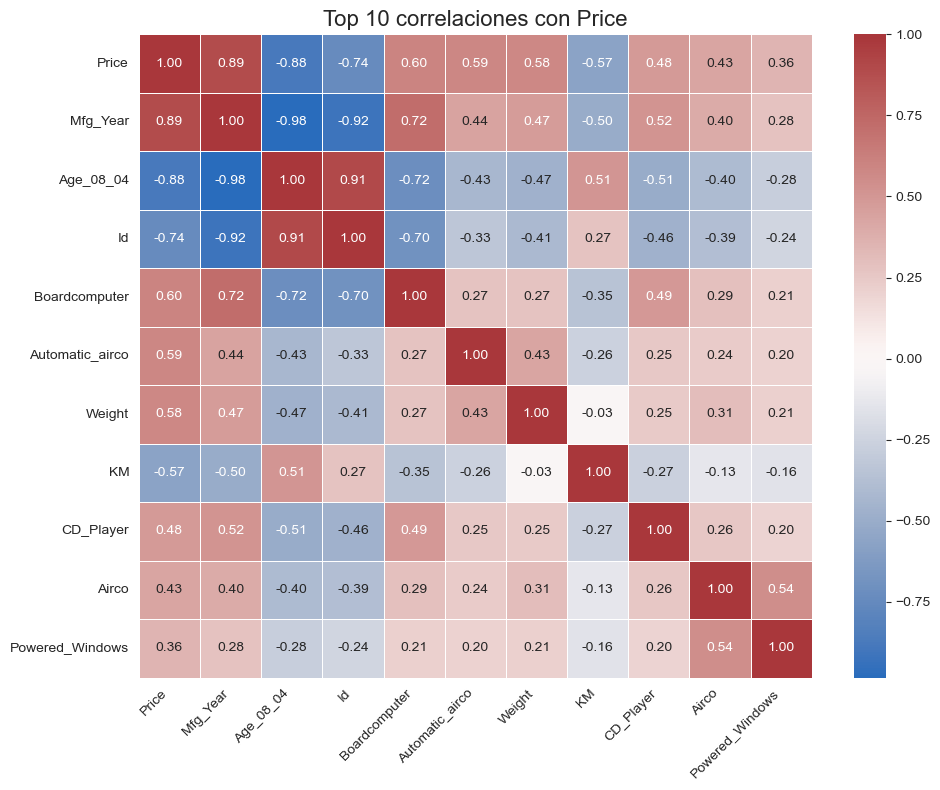

In [28]:
# 1. Ordenamos por |correlación| absoluta con Price
top_vars = (corr['Price']
            .abs()
            .sort_values(ascending=False)
            .head(11)   # Price + 10 más altas
            .index)

# 2. Filtramos la sub-matriz
sub_corr = corr.loc[top_vars, top_vars]

# 3. Graficamos sólo ese cuadrante
plt.figure(figsize=(10, 8))
sns.heatmap(
    sub_corr,
    cmap="vlag",
    annot=True,
    fmt=".2f",
    linewidths=.5,
    center=0
)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 correlaciones con Price", fontsize=16)
plt.tight_layout()
plt.show()


Id
Identificador único de cada vehículo en el dataset.

Model
Versión o acabado del Toyota Corolla (por ejemplo, “Corolla D”, “Corolla GLi”).

Price
Precio de venta del automóvil (en la unidad monetaria del dataset, p. ej., euros u otra).

Age_08_04
Edad del coche, en años, referida al 4 de agosto de 2004 (fecha de corte utilizada para calcular antigüedad).

Mfg_Month
Mes de fabricación del vehículo (1 = enero … 12 = diciembre).

Mfg_Year
Año de fabricación del vehículo.

KM
Kilometraje recorrido por el coche (en kilómetros).

Fuel_Type
Tipo de combustible:

“Petrol” (gasolina)

“Diesel” (diésel)

“CNG” (gas natural comprimido)

HP
Potencia del motor en caballos de fuerza (Horse Power).

Met_Color
Indicador de pintura metálica (1 = sí, 0 = no).

Automatic
Tipo de transmisión (1 = automática, 0 = manual).

cc
Cilindrada del motor en centímetros cúbicos (cm³).

Doors
Número de puertas del vehículo.

Cylinders
Número de cilindros del motor.

Gears
Número de marchas de la transmisión.

Quarterly_Tax
Importe del impuesto de circulación o matriculación que se paga trimestralmente (en la misma unidad monetaria que Price).

Weight
Peso del vehículo en kilogramos.

Mfr_Guarantee
Garantía del fabricante (1 = incluida, 0 = no incluida).

BOVAG_Guarantee
Garantía ofrecida por BOVAG (asociación neerlandesa de concesionarios) (1 = incluida, 0 = no).

Guarantee_Period
Duración de la garantía (en años).

ABS
Sistema antibloqueo de frenos (Anti-lock Braking System) (1 = sí, 0 = no).

Airbag_1
Airbag para el conductor (1 = sí, 0 = no).

Airbag_2
Airbag para el pasajero delantero (1 = sí, 0 = no).

Airco
Aire acondicionado (1 = sí, 0 = no).

Automatic_airco
Control automático de la temperatura (climatizador) (1 = sí, 0 = no).

Boardcomputer
Ordenador de a bordo (display con información de viaje, consumo, etc.) (1 = sí, 0 = no).

CD_Player
Reproductor de CD (1 = sí, 0 = no).

Central_Lock
Cierre centralizado de puertas (1 = sí, 0 = no).

Powered_Windows
Elevalunas eléctricos (1 = sí, 0 = no).

Power_Steering
Dirección asistida (1 = sí, 0 = no).

Radio
Radio estándar (1 = sí, 0 = no).

Mistlamps
Faros antiniebla (1 = sí, 0 = no).

Sport_Model
Edición deportiva del modelo (1 = sí, 0 = no).

Backseat_Divider
Separador o consola entre asientos traseros (1 = sí, 0 = no).

Metallic_Rim
Llantas de aleación metálica (1 = sí, 0 = no).

Radio_cassette
Radio con reproductor de casete (1 = sí, 0 = no).

Tow_Bar
Enganche de remolque o bola de remolque (1 = sí, 0 = no).